<a href="https://colab.research.google.com/github/kalpana-21/OutlierDetection/blob/main/OutlierDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

! matplotlib inline

/bin/bash: matplotlib: command not found


In [ ]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [ ]:
# this pre-processing code of the KDD dataset is adapter from https://github.com/lironber/GOAD/blob/master/data_loader.py

df_colnames = pd.read_csv('data.csv', skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']

df = pd.read_csv('kddcup.data_10_percent.gz', header=None, names=df_colnames['f_names'].values)
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [ ]:
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [ ]:
attack_samples.shape

(396743, 120)

In [ ]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [ ]:
X_train.shape


(77822, 120)

In [ ]:
X_test.shape


(38912, 120)

In [ ]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 120)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 60)           7260        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 40)           2440        ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 40)           2440        ['dense_3[0][0]']                
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 40)]              0         
                                                                 
 dense_4 (Dense)             (None, 60)                2460      
                                                                 
 dense_5 (Dense)             (None, 120)               7320      
                                                                 
Total params: 9,780
Trainable params: 9,780
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 120)]             0         
                                                                 
 encoder (Functional)        (None, 40)                12140     
                                                                 
 decoder (Functional)        (None, 120)               9780      
                                                                 
Total params: 21,920
Trainable params: 21,920
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
opt = optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=50,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 120)]             0         
                                                                 
 encoder (Functional)        (None, 40)                12140     
                                                                 
 decoder (Functional)        (None, 120)               9780      
                                                                 
Total params: 21,920
Trainable params: 21,920
Non-trainable params: 0
_________________________________________________________________
Train on 77822 samples
Epoch 1/50
77822/77822 [==============================] - 2s 29us/sample - loss: 5360.5656
Epoch 2/50
77822/77822 [==============================] - 3s 33us/sample - loss: 813.2273
Epoch 3/50
77822/77822 [==============================] - 2s 22us/sample - loss: 399.4319
Epoch 4/50
77822/77822 [=

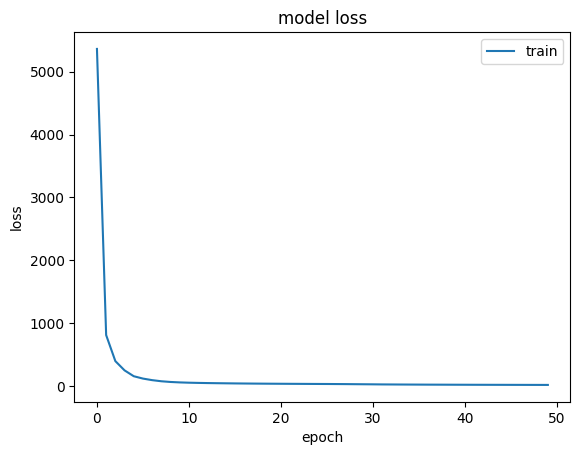

In [ ]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
X_train_pred = vae_model.predict(X_train)


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.0027663858851827467
median error 0.001989720240451976
99Q: 0.01387315247838088
setting threshold on 0.01387315247838088 


In [ ]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.4560289884868421

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94     19456
         1.0       0.98      0.90      0.94     19456

    accuracy                           0.94     38912
   macro avg       0.95      0.94      0.94     38912
weighted avg       0.95      0.94      0.94     38912



In [ ]:
X_pred.shape

(38912, 120)

In [ ]:
X_encoded = encoder.predict(X_test)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
!pip install "numpy<1.24"

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs00000000e477d16100000170'



In [ ]:
np.float = float
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

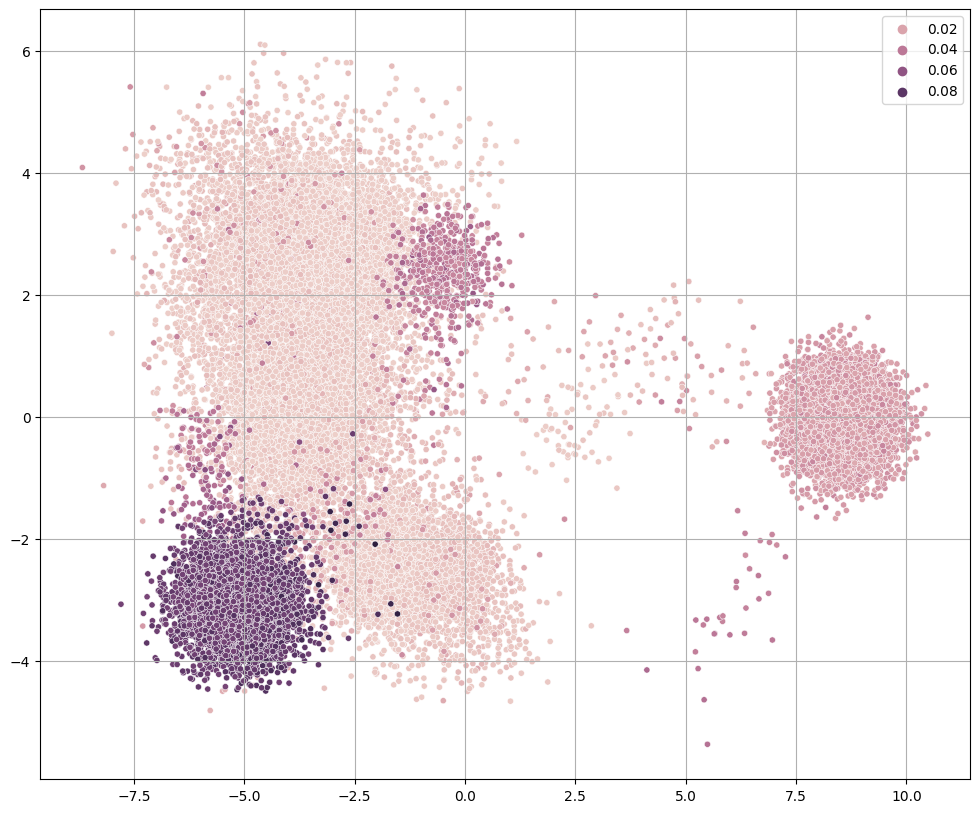

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

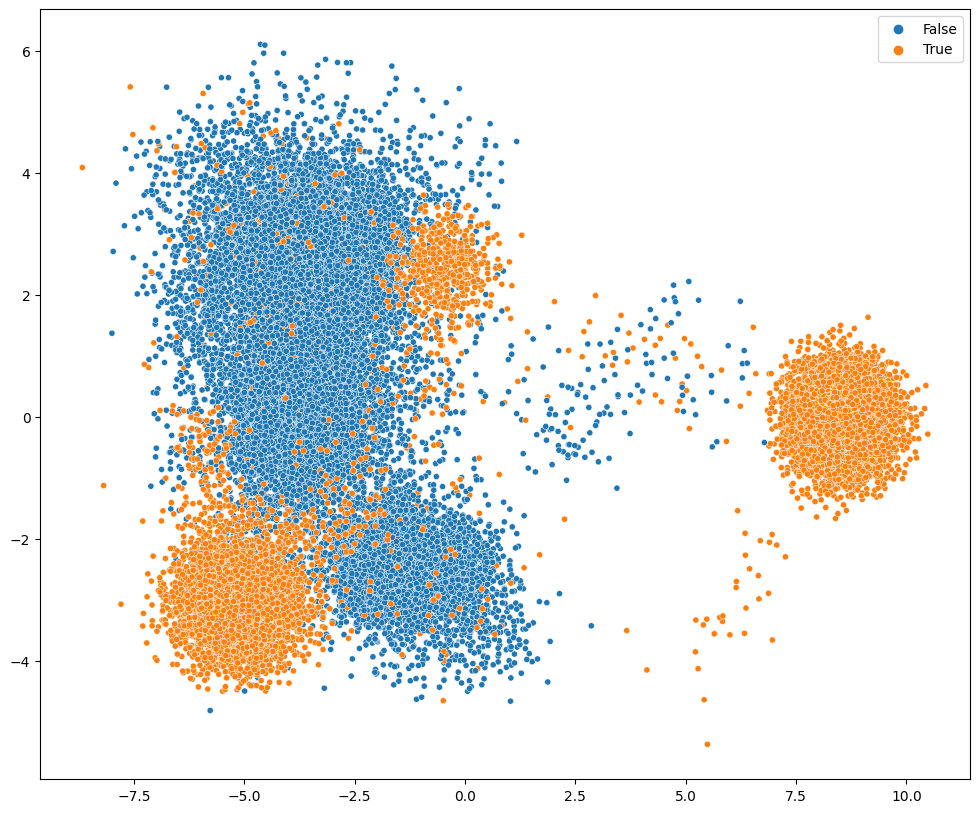

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.show()

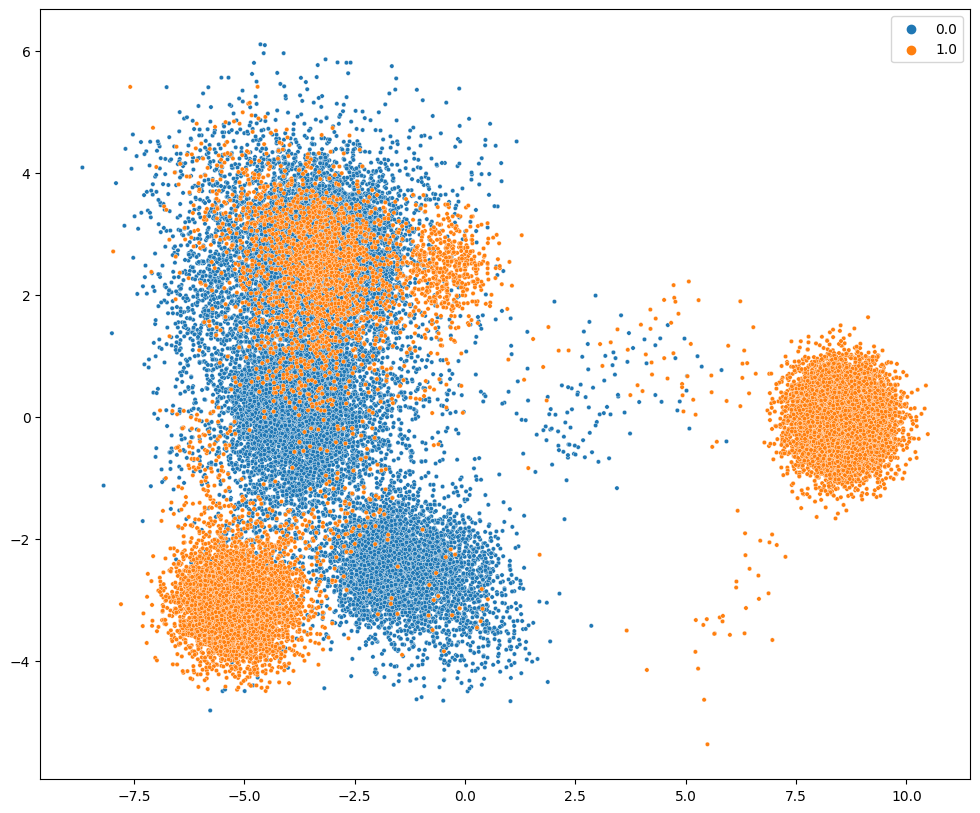

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)

plt.show()